In [1]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438347 sha256=538496d1ad34f3f34045c98e718388f153c475a347875dd59ed4bf7629e04148
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle

from mpi4py import MPI

In [3]:
def change_y(y, changes):
    y = y.copy()

    for change in changes:
        y = y + change

    return y

In [4]:
t = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, 3 ** 9)

changes = [np.zeros_like(t), 
           np.sin(3 * t) * np.exp(-(t - 5 * 2 * np.pi) ** 2 / (2 * 20 ** 2)), 
           np.sin(5.5 * t) * np.exp(-(t + 10 * 2 * np.pi) ** 2 / (2 * 5 ** 2)),
           np.sin(4 * t) * np.exp(-(t - 7 * 2 * np.pi) ** 2 / (2 * 10 ** 2))]

y = np.sin(t) * np.exp(-t ** 2 / (2 * 20 ** 2))

In [5]:
y_changed = change_y(y, changes)

In [6]:
def plot_signal_freq(t, y):

    val = np.abs(np.fft.fft(y)[:len(y) // 2]) ** 2
    freq = np.fft.fftfreq(len(y), d=(t[1] - t[0]) / (2 * np.pi))[:len(y) // 2]

    plt.figure(figsize=(10, 8))
    plt.plot(freq, val)

    plt.xlim(0., 8.)
    plt.xlabel('Frequency')
    plt.ylabel('Power spectrum')

    plt.show()

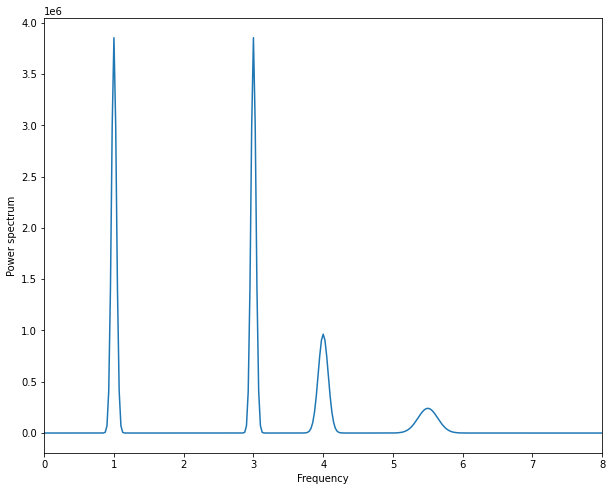

In [7]:
plot_signal_freq(t, y_changed)

In [8]:
with open(f't.pkl', 'wb') as f:
    pickle.dump(t, f)

with open(f'y.pkl', 'wb') as f:
    pickle.dump(y_changed, f)

In [9]:
%%writefile mpi_spectogram.py

import numpy as np
import pickle
import sys

from mpi4py import MPI

def spectrogram(t, y, window_positions_range, window_width = 4.0 * 2 * np.pi):
    
    t_size = len(t) // 2

    spectrogram = np.zeros((len(window_positions_range), t_size), dtype=np.float32)

    for i, window_position in enumerate(window_positions_range):
        window_function = np.exp(-(t - window_position) ** 2 / (2 * window_width**2))
        y_window = (y * window_function)

        values = np.abs(np.fft.fft(y_window)) ** 2
        spectrogram[i, :] = values[:t_size]

    return np.log(1 + spectrogram).reshape(-1)


comm = MPI.COMM_WORLD
start = MPI.Wtime()

rank = comm.Get_rank()
size = comm.Get_size()
root = 0

### read parameters of signal

with open(f't.pkl', 'rb') as f:
    t = pickle.load(f)

with open(f'y.pkl', 'rb') as f:
    y = pickle.load(f)

t_size = len(t) // 2


n_window_steps = 1000 if len(sys.argv) < 2 else int(sys.argv[1])
window_width = 4.0 * 2 * np.pi if len(sys.argv) < 3 else int(sys.argv[2])

window_positions = np.linspace(-30 * 2 * np.pi, 30 * 2 * np.pi, n_window_steps, dtype=np.float32)
frequencies = np.fft.fftfreq(len(y), d=(t[1] - t[0]) / (2 * np.pi))[:t_size]

window_positions_count = int(len(window_positions) / size)
window_positions_range = window_positions[rank * window_positions_count:(rank + 1) * window_positions_count]
spectrogram_complete = np.empty(t_size * len(window_positions), dtype=np.float32) if rank == root else None


spectrogram_range = spectrogram(t.astype(np.float32), y.astype(np.float32), window_positions_range, window_width)

comm.Gather(spectrogram_range, spectrogram_complete, root)
end = MPI.Wtime()

### creating dumps for parameters
if rank == root:

    with open(f'positions-{size}.pkl', 'wb') as f:
        pickle.dump(window_positions, f)
    
    with open(f'frequencies-{size}.pkl', 'wb') as f:
        pickle.dump(frequencies, f)

    with open(f'spectrogram-{size}.pkl', 'wb') as f:
        pickle.dump(spectrogram_complete.reshape(len(window_positions), t_size).T, f)
    
    with open(f'time-{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Writing mpi_spectogram.py


In [10]:
n_processes = 8
!mpirun --allow-run-as-root -n {n_processes} python3 mpi_spectogram.py {int(2e4)}

In [12]:
with open(f'positions-{n_processes}.pkl', 'rb') as f:
    window_positions = pickle.load(f)

with open(f'frequencies-{n_processes}.pkl', 'rb') as f:
    frequencies = pickle.load(f)
    
with open(f'spectrogram-{n_processes}.pkl', 'rb') as f:
    spectrogram_complete = pickle.load(f)

In [20]:
def plot_spectrogram(window_positions, frequencies, spectrogram):
    plt.figure(figsize=(10, 10))
    plt.imshow(spectrogram, interpolation='nearest', aspect='auto',
            extent=[window_positions.min() / (2 * np.pi), window_positions.max() / (2 * np.pi), frequencies.max(), frequencies.min()])

    plt.ylim(0, 7)
    plt.xlabel('$t$, cycles')
    plt.ylabel('Power spectrum')
    plt.savefig('spectogram.png')

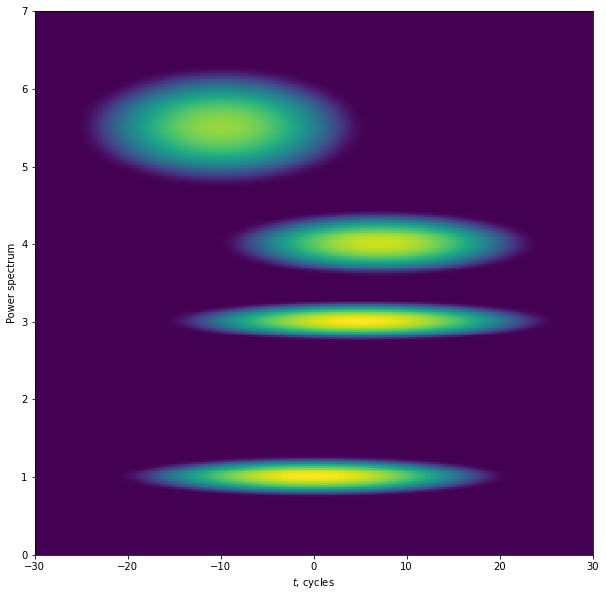

In [21]:
plot_spectrogram(window_positions, frequencies, spectrogram_complete)

In [15]:
nn = np.logspace(0, 2, base=2, num=3).astype(np.int)

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 mpi_spectogram.py {int(2e4)}

<ipython-input-15-1b5947a36c21>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nn = np.logspace(0, 2, base=2, num=3).astype(np.int)


In [16]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

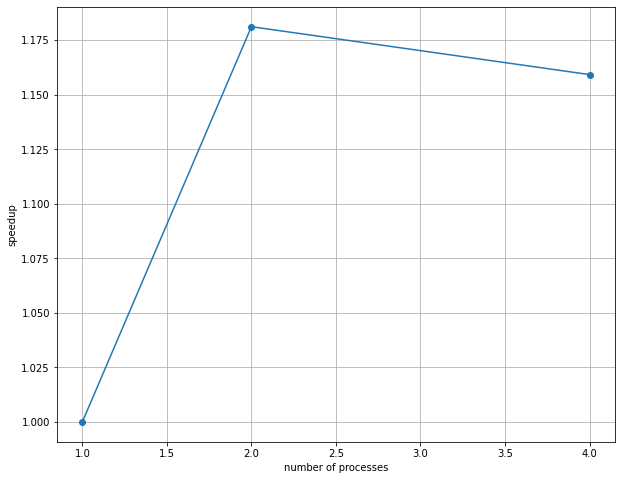

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes')
plt.ylabel('speedup')

plt.grid()
plt.show()

not a linear relationship with number of processes but the speed does increase 